In [1]:
import utils_data as ut
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertForMaskedLM, BertTokenizer
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=512)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')

In [2]:
classes = {'POLYMER': 1,
           'ORGANIC': 2,
           'MONOMER': 3,
           'PROP_NAME': 4,
           'INORGANIC': 5,
           'MATERIAL_AMOUNT': 6,
           'POLYMER_FAMILY': 7,
           'PROP_VALUE': 8,
           'O': 0}
max_length = 512
batch_size = 3
class NERBERTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = modelBERT.base_model
        self.linear = nn.Linear(768, len(classes) + 1)
        
    def forward(self, token, attention_mask):
        encoder_output= self.bert(token, attention_mask)  # torch.LongTensor of shape (batch_size, sequence_length)
        linear_output = self.linear(encoder_output.last_hidden_state)
        class_output = F.softmax(linear_output, dim=2)
        return class_output

In [3]:
model = NERBERTModel()

In [4]:
num_data = 100
data_list = ut.read_data('train.json', max_length)[:num_data]

In [5]:
token_tensors_all_list = [ut.list2token(tokenizerBERT, d['words'], max_length) for d in data_list]
data = torch.cat(token_tensors_all_list, dim=0)
data_batches = ut.to_batches(data, batch_size)
target_tensors_all_list = [ut.cat2digit(classes, d['ner'], max_length)[0] for d in data_list]
target = torch.stack(target_tensors_all_list, dim=0)
target_batches = ut.to_batches(target, batch_size)
att_mask_all_list = [ut.cat2digit(classes, d['ner'], max_length)[1] for d in data_list]
att_mask = torch.stack(att_mask_all_list, dim=0)
att_mask_batches = ut.to_batches(att_mask, batch_size)

In [6]:
c = list(zip(data_batches, target_batches, att_mask_batches))
random.shuffle(c)
data_batches, target_batches, att_mask_batches = zip(*c)

In [7]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.01, 0.5, 1, 1, 1, 1, 1, 1, 0.5, 0.0]))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
torch.manual_seed(10)

In [8]:
epochs = 8
train_losses = []
train_accuracy = []
for epoch in range(epochs):
    train_loss_batch = []
    train_accuracy_batch = []
    for b, X in enumerate(data_batches):
        y_pred = model(X, attention_mask=att_mask_batches[b])
        y_pred = torch.swapaxes(y_pred, 1, 2)
        y = target_batches[b]
        
        loss = criterion(y_pred, y)
        acc, predicted_classes, true_classes = ut.accuracy(0, len(classes), y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_batch.append(loss.item())
        train_accuracy_batch.append(acc)
        if b % 10 == 0:
#             print(f'epoch: {epoch:2}  batch: {b:3}  loss: {loss.item():.6f}   accuracy: {acc:.4f}')
#             print(predicted_classes)
#             print(true_classes)
    
    train_loss_batch_mean = sum(train_loss_batch) / len(train_loss_batch)
    train_accuracy_batch_mean = sum(train_accuracy_batch) / len(train_accuracy_batch)    
    print(f'mean training loss at epoch {epoch}: {train_loss_batch_mean}')
    print(f'mean training accuracy at epoch {epoch}: {train_accuracy_batch_mean}')
    train_losses.append(train_loss_batch_mean)
    train_accuracy.append(train_accuracy_batch_mean)

epoch:  0  batch:   0  loss: 2.302231   accuracy: 0.0333
tensor([4, 5, 4, 5, 5, 5, 5, 8, 4, 5, 5, 7, 5, 5, 7, 5, 5, 5, 9, 7, 5, 7, 7, 5,
        7, 5, 7, 5, 4, 5, 5, 4, 4, 2, 4, 5, 5, 2, 5, 4, 4, 5, 5, 5, 5, 5, 4, 4,
        5, 8, 9, 4, 5, 4, 5, 5, 4, 5, 4, 7, 5, 4, 5, 5, 4, 5, 5, 4, 7, 4, 5, 7,
        4, 7, 2, 0, 0, 0, 0, 5, 7, 5, 4, 7, 4, 4, 7, 4, 5, 4])
tensor([3, 3, 3, 3, 7, 7, 4, 4, 8, 8, 8, 8, 7, 7, 7, 7, 4, 4, 8, 8, 8, 8, 4, 4,
        4, 8, 8, 8, 8, 4, 4, 8, 8, 4, 4, 4, 8, 8, 8, 8, 8, 4, 4, 4, 4, 8, 8, 8,
        7, 4, 4, 8, 8, 8, 4, 4, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 4, 4, 1, 1, 6, 6,
        6, 6, 6, 4, 4, 4, 4, 8, 8, 8, 8, 1, 1, 6, 1, 1, 1, 7])
epoch:  0  batch:  10  loss: 1.879876   accuracy: 0.7821
tensor([4, 1, 1, 1, 1, 1, 1, 4, 4, 1, 8, 1, 1, 4, 1, 1, 1, 4, 4, 8, 8, 8, 8, 8,
        8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        4, 4, 1, 1, 1, 8, 8, 8, 8, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
tensor([7, 1,

epoch:  2  batch:  30  loss: 2.008190   accuracy: 0.5096
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 8, 8, 8, 8, 8,
        8, 8, 8, 4, 8, 8, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 4, 4, 1, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4,
        8, 4, 4, 4, 8, 4, 4, 0])
tensor([3, 3, 3, 3, 3, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 7, 7, 4, 4, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 7, 1, 1, 1, 1, 5, 5,
        2, 6, 6, 6, 1, 5, 4, 4, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 5, 5,
        5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 5, 5, 5, 5, 5, 5, 1, 4, 4, 4,
        8, 4, 4, 4, 8, 4, 4, 4])
mean training loss at epoch 2: 1.8544658212100757
mean training accuracy at epoch 2: 0.6732884049415588
epoch:  3  batch:   0  loss: 1.799857   accuracy: 0.7000
tensor([1, 0, 1, 1, 1, 1, 0, 1, 8, 8, 8, 8, 1, 1, 1, 1, 4, 4, 8, 8, 8, 8, 4,

epoch:  5  batch:  20  loss: 1.825515   accuracy: 0.5985
tensor([1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 1, 1, 1, 4, 4,
        6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4,
        4, 6, 6, 6, 1, 1, 1, 4, 1, 1, 4, 4, 4, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 1, 1])
tensor([5, 5, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 3, 7, 7, 2, 6,
        6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8,
        4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 4, 4, 4, 4, 4, 8, 8, 8, 4, 4, 4, 8,
        8, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 7, 4, 4, 4,
        1, 6, 6, 6, 1, 1, 1, 1, 1, 1, 4, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 7])
epoch:  5  batch:  30  

In [11]:
train_accuracy

[2.0458991913234486,
 1.9010677758385153,
 1.8544658212100757,
 1.8171810893451465,
 1.815569299108842,
 1.8794062944019543,
 1.8464231035288643,
 1.8115406772669624]

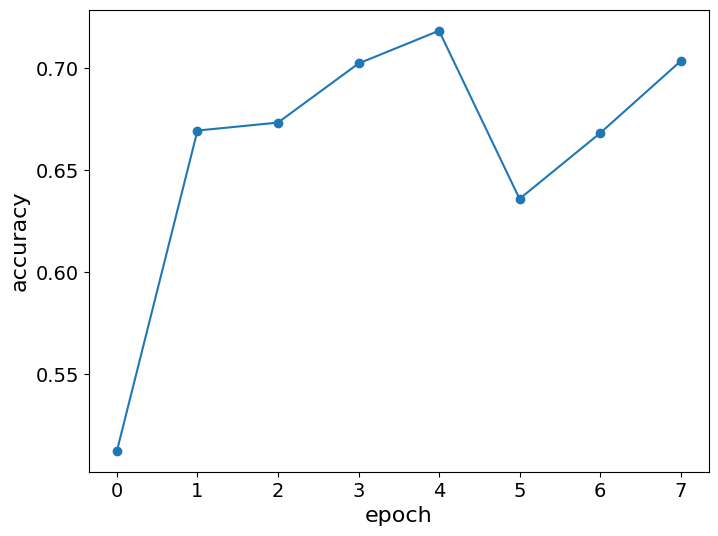

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_accuracy, 'o-')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

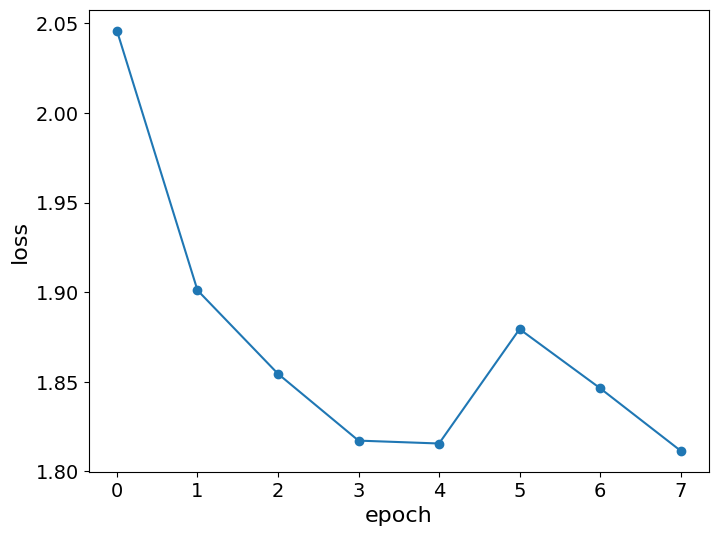

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, 'o-')
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()